Identify of transh-up and transh-down bin triads in WE and PnM data. 
Draw venn diagrams (Figure 2C) and analyze clustering of contacts (Figure 3 A-C).

In [3]:
import pandas as pd
import numpy as np
import itertools
import seaborn as sns
import pybedtools as pbt
from matplotlib_venn import venn2, venn2_circles
import matplotlib.pyplot as plt
from statannotations.Annotator import Annotator
from scipy import stats

In [2]:
pbt.set_tempdir('../../tmp')

In [3]:
%load_ext rpy2.ipython

In [4]:
%%R
library("DESeq2")

R[write to console]: Loading required package: S4Vectors

R[write to console]: Loading required package: stats4

R[write to console]: Loading required package: BiocGenerics

R[write to console]: Loading required package: parallel

R[write to console]: 
Attaching package: ‘BiocGenerics’


R[write to console]: The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB


R[write to console]: The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


R[write to console]: The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, Position, 

In [5]:
%%R
packageVersion("DESeq2")

[1] ‘1.30.1’


In [6]:
#Input
WE_datafiles = ["../../data/haplotype_HiC/bam/all_reads/HiC_D_mel_DGRP-57_DGRP-439_WE_2-4h_Rep1.pairs.fully_phased.tsv.gz",
                "../../data/haplotype_HiC/bam/all_reads/HiC_D_mel_DGRP-57_DGRP-439_WE_2-4h_Rep2.pairs.fully_phased.tsv.gz"]

PnM_datafiles = ["../../data/haplotype_HiC/bam/all_reads/HiC_D_mel_DGRP-57_DGRP-439_PnM_Rep1.pairs.fully_phased.tsv.gz",
                 "../../data/haplotype_HiC/bam/all_reads/HiC_D_mel_DGRP-57_DGRP-439_PnM_Rep2.pairs.fully_phased.tsv.gz"]
#Output
tables = "../../results/csv/"
figures = "../../results/fig/"

In [7]:
!zcat ../../data/haplotype_HiC/bam/all_reads/HiC_D_mel_DGRP-57_DGRP-439_WE_2-4h_Rep1.pairs.fully_phased.tsv.gz | head

chrom1	pos1	strand1	haplotype1	chrom2	pos2	strand2	haplotype2
3R	24607710	-	DGRP-57	3R	24701755	+	DGRP-57
3R	15280387	-	DGRP-57	3R	15286147	+	DGRP-57
2R	14955488	+	DGRP-57	2R	14955879	-	DGRP-57
3R	19074941	-	DGRP-57	3R	19074677	+	DGRP-57
2R	23600974	+	DGRP-57	2R	23588557	-	DGRP-57
3R	20316101	-	DGRP-439	3R	20315733	+	DGRP-439
2R	11593119	+	DGRP-439	2R	11593718	-	DGRP-439
3L	13232213	+	DGRP-57	3L	13232600	-	DGRP-57
3L	16496093	-	DGRP-439	3L	16495774	+	DGRP-439

gzip: stdout: Broken pipe


In [8]:
def order_positions(row):
    if row["pos1"] < row["pos2"]:
        return row
    else:
        pos1 = row["pos2"]
        pos2 = row["pos1"]
        row["pos1"] = pos1
        row["pos2"] = pos2
        
        h1 = row["haplotype2"]
        h2 = row["haplotype1"]
        row["haplotype1"] = h1
        row["haplotype2"] = h2
        
        s1 = row["strand2"]
        s2 = row["strand1"]
        row["strand1"] = h1
        row["strand2"] = h2
        
        return row
    
def read_interactions_assign_bins(counts_file, replicate):
    '''read contacts, select trans-homologous interactions with dist above 1kb and assign bins'''
    df = pd.read_csv(counts_file, sep = "\t")
    df = df.apply(order_positions, axis=1)
    df = df.rename(columns = {"haplotype1":"h1", "haplotype2":"h2"})
    df["transh"] = df["h1"] != df["h2"]
    df["pos1-1"] = df["pos1"] - 1
    df["pos2-1"] = df["pos2"] - 1
    df["interactionID"] = df.index
    df["replicate"] = replicate
    df_homologous = df[df["chrom1"] == df["chrom2"]].copy()
    df_homologous = df_homologous.rename(columns = {"chrom1":"chrom"}).drop(labels = ["chrom2"], axis=1)
    df_homologous["dist"] = df_homologous["pos2"] - df_homologous["pos1"]
    df_homologous_above1kb = df_homologous[df_homologous["dist"] > 1000].copy()
    df_homologous_above1kb["chrom"] = "chr" + df_homologous_above1kb["chrom"]
    
    # assign bin name
    x = pbt.BedTool()
    dm6_bins = x.window_maker(genome = "dm6", w = 2500)

    for s in ["1","2"]:
        pos_bedtool = pbt.BedTool.from_dataframe(df_homologous_above1kb[["chrom", "pos%s-1" % s, "pos%s" % s, "h%s" % s, "transh", "interactionID", "replicate"]])
        intersection = pos_bedtool.intersect(dm6_bins, wa = True, wb = True)
        intersection_df = intersection.to_dataframe(names = ["chrom", "pos%s-1" % s, "pos%s" % s, "h%s" % s, "transh", 
                                                             "interactionID", "replicate", "bin_chrom", "bin_start", "bin_end"])
        intersection_df["bin_name%s" % s] = intersection_df["bin_chrom"] + ":" + intersection_df["bin_start"].astype(str) + "-" + intersection_df["bin_end"].astype(str)
        df_homologous_above1kb = pd.merge(df_homologous_above1kb, intersection_df[["interactionID", "bin_name%s" % s]], on = "interactionID", how = "left")
        
    return df_homologous_above1kb

In [9]:
def prepare_counts_and_factors(dataset_prefix, merged_replicates_df):
    '''
    dataset_prefix: WE or PnM
    '''
    
    factors_sep_hap_dict = {"names" : [], "replicate" : [], "contactType" : []}
    all_counts_sep_hap_df = pd.DataFrame()

    for contact_type, replicate in list(itertools.product(["cish", "transh"], ["Rep1", "Rep2"])):
        print(contact_type, replicate)
        dataset_name = "_".join([dataset_prefix, contact_type, replicate])

        factors_sep_hap_dict["names"].append(dataset_name)
        factors_sep_hap_dict["replicate"].append(replicate)
        factors_sep_hap_dict["contactType"].append(contact_type)

        #count occurences of each pair type in a contact_type-haplotype_replicate data subset
        haplotype_counts = []
        for haplotype in ["DGRP-57", "DGRP-439"]:    
            for bin_num in ["1", "2"]:

                df_subset = merged_replicates_df[(merged_replicates_df["transh"] == (contact_type=="transh")) 
                                                & (merged_replicates_df["h" + bin_num] == haplotype) 
                                                & (merged_replicates_df["replicate"] == replicate)]
                counts = df_subset.groupby(["bin_name1", "bin_name2"]).size().reset_index(name = dataset_name)

                # the "h%s" % bin_num part of the name informs for which bin of the pair the haplotype condition is fulfilled - this is important for trans interactions
                # cis interactions are repeated twice
                counts["bin_pair"] = haplotype + "_locus" + bin_num + "_" + counts["bin_name1"] + "_" + counts["bin_name2"]
                counts = counts.reindex(["bin_pair", dataset_name], axis=1)
                haplotype_counts.append(counts)

        haplotype_counts_df = pd.concat(haplotype_counts)
        try:
            all_counts_sep_hap_df = pd.merge(all_counts_sep_hap_df, haplotype_counts_df, on = "bin_pair", how = "outer").fillna(0)
        except:
            all_counts_sep_hap_df = haplotype_counts_df

    factors_sep_hap_df = pd.DataFrame(factors_sep_hap_dict)
    factors_sep_hap_df[""] = factors_sep_hap_df["names"]
    factors_sep_hap_df = factors_sep_hap_df.set_index("")

    all_counts_sep_hap_df = all_counts_sep_hap_df.rename(columns = {"bin_pair":""}).set_index("")
    
    return factors_sep_hap_df, all_counts_sep_hap_df

In [10]:
%%R 
run_deseq <- function(factors, counts, figures, prefix) {
    dds_raw_all <- DESeqDataSetFromMatrix(countData = counts, colData = factors, design = ~ contactType)

    #plotPCA
    vsd <- vst(dds_raw_all)    
    #save PCA plot to file
    pdf(file=paste(figures,prefix,"_PCA.pdf", sep = ""))
    print(plotPCA(vsd, intgroup=c("contactType", "replicate")))
    dev.off()

    # filter by normalized count
    dds <- estimateSizeFactors(dds_raw_all)
    idx1 <- rowMeans(counts(dds, normalized=TRUE)) >= 1
    dds1 <- dds[idx1,]

    #run DESeq
    dds1 <- DESeq(dds1)

    res1 <- results(
        dds1,
        contrast = c("contactType", "transh", "cish"),
        alpha = 0.05
      )
    print(summary(res1))

    plotDispEsts(dds1)

    plotMA(res1, ylim = range(res1$log2FoldChange, na.rm = TRUE), alpha = 0.05)
    
    return(as.data.frame(res1))
}

In [11]:
def run_analysis(dataset, prefix):
    counts_file = tables + "%s_counts.csv" % prefix
    output_file_all = tables + "%s_all_deseq_results.csv" % prefix
    output_file = tables + "%s_diff_bin_pairs.csv" % prefix
    
    print(prefix)
    print("Counting interactions in bins")
    print([(datafile, "Rep%s" % str(i+1)) for i, datafile in enumerate(dataset)])
    counts_in_replicates = [read_interactions_assign_bins(datafile, "Rep%s" % str(i+1)) for i, datafile in enumerate(dataset)]
    merged_replicates = pd.concat(counts_in_replicates)
    merged_replicates_diff_bins = merged_replicates[merged_replicates["bin_name1"] != merged_replicates["bin_name2"]]
    contacts[prefix] = merged_replicates_diff_bins
    
    print("Preparing DESeq input")
    factors, counts = prepare_counts_and_factors(prefix, merged_replicates_diff_bins)
    counts_dict[prefix] = counts
    counts.to_csv(counts_file, sep = "\t")
    print("Running DESeq")

    %Rpush factors counts figures prefix
    deseq_results = %R run_deseq(factors, counts, figures, prefix)
    print("Saving all DESeq2 results to:", output_file_all)
    deseq_results.to_csv(output_file_all, sep = "\t")
    
    significant = deseq_results[deseq_results["padj"] < 0.05].copy()
    significant_results[prefix] = significant
    print("Saving significant bin triads to:", output_file)
    significant.to_csv(output_file, sep = "\t")

    significant["bin pair"] = "chr" + significant.index.str.split("_chr").str[1]
    bins_up = len(significant[significant["log2FoldChange"] > 0]["bin pair"].unique())
    comparisons_up = len(significant[significant["log2FoldChange"] > 0])
    bins_down = len(significant[significant["log2FoldChange"] < 0]["bin pair"].unique())
    comparisons_down = len(significant[significant["log2FoldChange"] < 0])
    print("For {} there are {} transh-up comparisons and {} bin pairs are involved in these. There are also {} transh-down comparisons for {} bin pairs".format(prefix, comparisons_up, 
                                                                                                                                                                bins_up, comparisons_down, bins_down))
    
    return significant, counts, merged_replicates_diff_bins

In [12]:
significant_results = {}
contacts = {}
counts_dict = {}

WE
Counting interactions in bins
[('../../data/haplotype_HiC/bam/all_reads/HiC_D_mel_DGRP-57_DGRP-439_WE_2-4h_Rep1.pairs.fully_phased.tsv.gz', 'Rep1'), ('../../data/haplotype_HiC/bam/all_reads/HiC_D_mel_DGRP-57_DGRP-439_WE_2-4h_Rep2.pairs.fully_phased.tsv.gz', 'Rep2')]


/home/magda/miniconda3/lib/python3.8/subprocess.py:849: RuntimeWarning: line buffering (buffering=1) isn't supported in binary mode, the default buffer size will be used
  self.stderr = io.open(errread, 'rb', bufsize)
/home/magda/miniconda3/lib/python3.8/subprocess.py:849: RuntimeWarning: line buffering (buffering=1) isn't supported in binary mode, the default buffer size will be used
  self.stderr = io.open(errread, 'rb', bufsize)
/home/magda/miniconda3/lib/python3.8/subprocess.py:849: RuntimeWarning: line buffering (buffering=1) isn't supported in binary mode, the default buffer size will be used
  self.stderr = io.open(errread, 'rb', bufsize)
/home/magda/miniconda3/lib/python3.8/subprocess.py:849: RuntimeWarning: line buffering (buffering=1) isn't supported in binary mode, the default buffer size will be used
  self.stderr = io.open(errread, 'rb', bufsize)
/home/magda/miniconda3/lib/python3.8/subprocess.py:849: RuntimeWarning: line buffering (buffering=1) isn't supported in binary m

Preparing DESeq input
cish Rep1
cish Rep2
transh Rep1
transh Rep2
Running DESeq


R[write to console]: converting counts to integer mode

R[write to console]: -- note: fitType='parametric', but the dispersion trend was not well captured by the
   function: y = a/x + b, and a local regression fit was automatically substituted.
   specify fitType='local' or 'mean' to avoid this message next time.

R[write to console]: using pre-existing size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: -- note: fitType='parametric', but the dispersion trend was not well captured by the
   function: y = a/x + b, and a local regression fit was automatically substituted.
   specify fitType='local' or 'mean' to avoid this message next time.

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing




out of 454436 with nonzero total read count
adjusted p-value < 0.05
LFC > 0 (up)       : 371, 0.082%
LFC < 0 (down)     : 6518, 1.4%
outliers [1]       : 0, 0%
low counts [2]     : 405263, 89%
(mean count < 4)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results

NULL


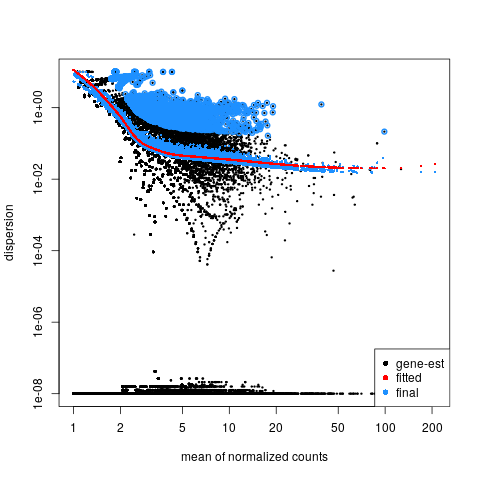

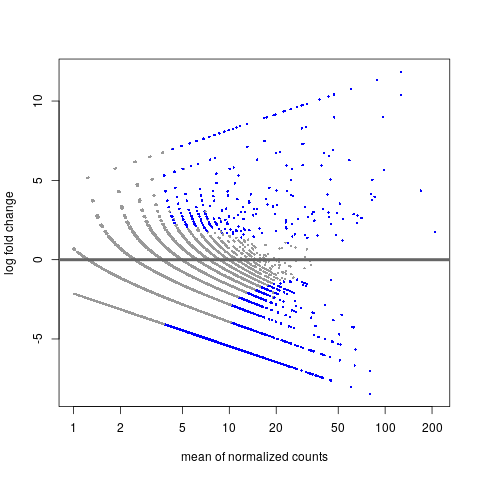

Saving all DESeq2 results to: ../../results/csv/WE_all_deseq_results.csv
Saving significant bin triads to: ../../results/csv/WE_diff_bin_pairs.csv
For WE there are 371 transh-up comparisons and 209 bin pairs are involved in these. There are also 6518 transh-down comparisons for 3249 bin pairs


In [76]:
significant_results["WE"], counts_dict["WE"], contacts["WE"] = run_analysis(WE_datafiles, "WE")

PnM
Counting interactions in bins
[('../../data/haplotype_HiC/bam/all_reads/HiC_D_mel_DGRP-57_DGRP-439_PnM_Rep1.pairs.fully_phased.tsv.gz', 'Rep1'), ('../../data/haplotype_HiC/bam/all_reads/HiC_D_mel_DGRP-57_DGRP-439_PnM_Rep2.pairs.fully_phased.tsv.gz', 'Rep2')]


/home/magda/miniconda3/lib/python3.8/subprocess.py:849: RuntimeWarning: line buffering (buffering=1) isn't supported in binary mode, the default buffer size will be used
  self.stderr = io.open(errread, 'rb', bufsize)
/home/magda/miniconda3/lib/python3.8/subprocess.py:849: RuntimeWarning: line buffering (buffering=1) isn't supported in binary mode, the default buffer size will be used
  self.stderr = io.open(errread, 'rb', bufsize)
/home/magda/miniconda3/lib/python3.8/subprocess.py:849: RuntimeWarning: line buffering (buffering=1) isn't supported in binary mode, the default buffer size will be used
  self.stderr = io.open(errread, 'rb', bufsize)
/home/magda/miniconda3/lib/python3.8/subprocess.py:849: RuntimeWarning: line buffering (buffering=1) isn't supported in binary mode, the default buffer size will be used
  self.stderr = io.open(errread, 'rb', bufsize)
/home/magda/miniconda3/lib/python3.8/subprocess.py:849: RuntimeWarning: line buffering (buffering=1) isn't supported in binary m

Preparing DESeq input
cish Rep1
cish Rep2
transh Rep1
transh Rep2
Running DESeq


R[write to console]: converting counts to integer mode

R[write to console]: using pre-existing size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: -- note: fitType='parametric', but the dispersion trend was not well captured by the
   function: y = a/x + b, and a local regression fit was automatically substituted.
   specify fitType='local' or 'mean' to avoid this message next time.

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing




out of 2746346 with nonzero total read count
adjusted p-value < 0.05
LFC > 0 (up)       : 97, 0.0035%
LFC < 0 (down)     : 3119, 0.11%
outliers [1]       : 0, 0%
low counts [2]     : 2289487, 83%
(mean count < 5)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results

NULL


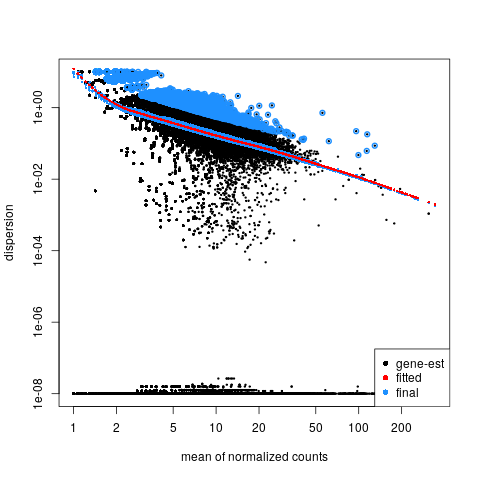

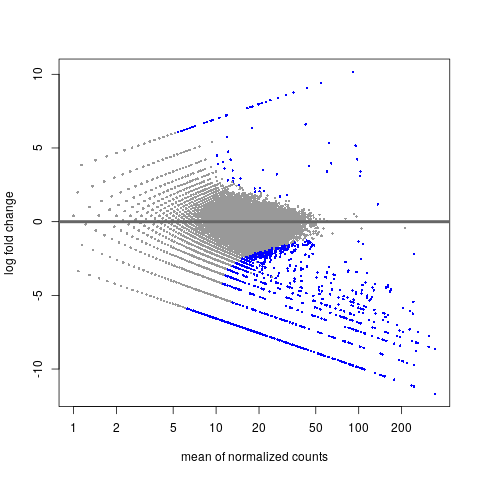

Saving all DESeq2 results to: ../../results/csv/PnM_all_deseq_results.csv
Saving significant bin triads to: ../../results/csv/PnM_diff_bin_pairs.csv
For PnM there are 97 transh-up comparisons and 70 bin pairs are involved in these. There are also 3119 transh-down comparisons for 1217 bin pairs


In [78]:
significant_results["PnM"], counts_dict["PnM"], contacts["PnM"] = run_analysis(PnM_datafiles, "PnM")

In [51]:
significant_results["PnM"].head()

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,bin pair,bin1,bin2,bin_name1,bin_name2,bin pair type
DGRP-57_locus1_chr2L:10875000-10877500_chr2L:10882500-10885000,92.201972,-5.297533,0.539083,-9.826939,8.619868e-23,7.292712e-19,chr2L:10875000-10877500,chr2L:10875000-10877500,chr2L:10882500-10885000,chr2L:10875000-10877500,chr2L:10882500-10885000,transDOWN
DGRP-57_locus1_chr2L:11562500-11565000_chr2L:11567500-11570000,10.378207,-6.625061,1.560225,-4.246221,2.174060e-05,1.082886e-02,chr2L:11562500-11565000,chr2L:11562500-11565000,chr2L:11567500-11570000,chr2L:11562500-11565000,chr2L:11567500-11570000,transDOWN
DGRP-57_locus1_chr2L:11620000-11622500_chr2L:11625000-11627500,16.060058,-2.810612,0.728042,-3.860507,1.131520e-04,2.904185e-02,chr2L:11620000-11622500,chr2L:11620000-11622500,chr2L:11625000-11627500,chr2L:11620000-11622500,chr2L:11625000-11627500,transDOWN
DGRP-57_locus1_chr2L:11625000-11627500_chr2L:11630000-11632500,18.063646,-2.246227,0.620293,-3.621236,2.931986e-04,4.574474e-02,chr2L:11625000-11627500,chr2L:11625000-11627500,chr2L:11630000-11632500,chr2L:11625000-11627500,chr2L:11630000-11632500,transDOWN
DGRP-57_locus1_chr2L:11660000-11662500_chr2L:11665000-11667500,7.568995,-6.169620,1.612010,-3.827284,1.295652e-04,3.100354e-02,chr2L:11660000-11662500,chr2L:11660000-11662500,chr2L:11665000-11667500,chr2L:11660000-11662500,chr2L:11665000-11667500,transDOWN


In [52]:
def find_affected_bin_and_haplotype(row):
    #on the allele indicated in pair name but on the other locus
    affected_allele = row.name.split("_")[0]
    if row.name.split("_")[1] == "locus1":
        affected_locus = row["bin2"]
    elif row.name.split("_")[1] == "locus2":
        affected_locus = row["bin1"]
    else:
        print(row.name.split("_")[1])
    
    row["affected allele"] = affected_allele
    row["affected bin"] = affected_locus
    
    return row

In [53]:
we_significant = significant_results["WE"]
we_significant["bin1"] = we_significant.index.str.split("_").str[2]
we_significant["bin2"] = we_significant.index.str.split("_").str[3]
we_significant = we_significant.apply(find_affected_bin_and_haplotype, axis=1)
we_significant.head()

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,bin pair,bin1,bin2,bin_name1,bin_name2,bin pair type,affected allele,affected bin
DGRP-57_locus1_chr2L:10000000-10002500_chr2L:10002500-10005000,11.328060,-3.026789,1.058510,-2.859482,0.004243,0.045783,chr2L:10000000-10002500,chr2L:10000000-10002500,chr2L:10002500-10005000,chr2L:10000000-10002500,chr2L:10002500-10005000,transDOWN,DGRP-57,chr2L:10002500-10005000
DGRP-57_locus1_chr2L:10025000-10027500_chr2L:10027500-10030000,4.884034,-4.421116,1.483977,-2.979234,0.002890,0.044235,chr2L:10025000-10027500,chr2L:10025000-10027500,chr2L:10027500-10030000,chr2L:10025000-10027500,chr2L:10027500-10030000,transDOWN,DGRP-57,chr2L:10027500-10030000
DGRP-57_locus1_chr2L:10190000-10192500_chr2L:10197500-10200000,3.908042,-4.106179,1.494520,-2.747490,0.006005,0.046718,chr2L:10190000-10192500,chr2L:10190000-10192500,chr2L:10197500-10200000,chr2L:10190000-10192500,chr2L:10197500-10200000,transDOWN,DGRP-57,chr2L:10197500-10200000
DGRP-57_locus1_chr2L:10210000-10212500_chr2L:10217500-10220000,3.973403,-4.134231,1.499326,-2.757392,0.005826,0.046499,chr2L:10210000-10212500,chr2L:10210000-10212500,chr2L:10217500-10220000,chr2L:10210000-10212500,chr2L:10217500-10220000,transDOWN,DGRP-57,chr2L:10217500-10220000
DGRP-57_locus1_chr2L:10212500-10215000_chr2L:10215000-10217500,11.605186,-2.394369,0.878435,-2.725720,0.006416,0.046838,chr2L:10212500-10215000,chr2L:10212500-10215000,chr2L:10215000-10217500,chr2L:10212500-10215000,chr2L:10215000-10217500,transDOWN,DGRP-57,chr2L:10215000-10217500


In [54]:
#supplementary table
we_significant[["bin1", "bin2", "affected allele", "affected bin", "baseMean", "log2FoldChange", "lfcSE", "stat", "pvalue", "padj"]].to_csv(tables + "WE_diff_bin_pairs_format.csv", index = False, sep = "\t")

In [55]:
pnm_significant = significant_results["PnM"]
pnm_significant["bin1"] = pnm_significant.index.str.split("_").str[2]
pnm_significant["bin2"] = pnm_significant.index.str.split("_").str[3]
pnm_significant = pnm_significant.apply(find_affected_bin_and_haplotype, axis=1)
pnm_significant.head()

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,bin pair,bin1,bin2,bin_name1,bin_name2,bin pair type,affected allele,affected bin
DGRP-57_locus1_chr2L:10875000-10877500_chr2L:10882500-10885000,92.201972,-5.297533,0.539083,-9.826939,8.619868e-23,7.292712e-19,chr2L:10875000-10877500,chr2L:10875000-10877500,chr2L:10882500-10885000,chr2L:10875000-10877500,chr2L:10882500-10885000,transDOWN,DGRP-57,chr2L:10882500-10885000
DGRP-57_locus1_chr2L:11562500-11565000_chr2L:11567500-11570000,10.378207,-6.625061,1.560225,-4.246221,2.174060e-05,1.082886e-02,chr2L:11562500-11565000,chr2L:11562500-11565000,chr2L:11567500-11570000,chr2L:11562500-11565000,chr2L:11567500-11570000,transDOWN,DGRP-57,chr2L:11567500-11570000
DGRP-57_locus1_chr2L:11620000-11622500_chr2L:11625000-11627500,16.060058,-2.810612,0.728042,-3.860507,1.131520e-04,2.904185e-02,chr2L:11620000-11622500,chr2L:11620000-11622500,chr2L:11625000-11627500,chr2L:11620000-11622500,chr2L:11625000-11627500,transDOWN,DGRP-57,chr2L:11625000-11627500
DGRP-57_locus1_chr2L:11625000-11627500_chr2L:11630000-11632500,18.063646,-2.246227,0.620293,-3.621236,2.931986e-04,4.574474e-02,chr2L:11625000-11627500,chr2L:11625000-11627500,chr2L:11630000-11632500,chr2L:11625000-11627500,chr2L:11630000-11632500,transDOWN,DGRP-57,chr2L:11630000-11632500
DGRP-57_locus1_chr2L:11660000-11662500_chr2L:11665000-11667500,7.568995,-6.169620,1.612010,-3.827284,1.295652e-04,3.100354e-02,chr2L:11660000-11662500,chr2L:11660000-11662500,chr2L:11665000-11667500,chr2L:11660000-11662500,chr2L:11665000-11667500,transDOWN,DGRP-57,chr2L:11665000-11667500


In [56]:
#supplementary table
pnm_significant[["bin1", "bin2", "affected allele", "affected bin", "baseMean", "log2FoldChange", "lfcSE", "stat", "pvalue", "padj"]].to_csv(tables + "PnM_diff_bin_pairs_format.csv", index = False, sep = "\t")

# Count and plot significant bin triads

In [57]:
merged = pd.merge(significant_results["WE"], significant_results["PnM"], left_index = True, right_index = True, suffixes = ("_we", "_pnm"), indicator = True, how = "outer")
merged.head()

,baseMean_we,log2FoldChange_we,lfcSE_we,stat_we,pvalue_we,padj_we,bin pair_we,bin1_we,bin2_we,bin_name1_we,...,stat_pnm,pvalue_pnm,padj_pnm,bin pair_pnm,bin1_pnm,bin2_pnm,bin_name1_pnm,bin_name2_pnm,bin pair type_pnm,_merge
DGRP-439_locus1_chr2L:10027500-10030000_chr2L:10030000-10032500,6.248121,-4.771685,1.481710,-3.220392,0.001280,0.039294,chr2L:10027500-10030000,chr2L:10027500-10030000,chr2L:10030000-10032500,chr2L:10027500-10030000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
DGRP-439_locus1_chr2L:10057500-10060000_chr2L:10062500-10065000,5.594862,-4.611189,1.485202,-3.104756,0.001904,0.042372,chr2L:10057500-10060000,chr2L:10057500-10060000,chr2L:10062500-10065000,chr2L:10057500-10060000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
DGRP-439_locus1_chr2L:10137500-10140000_chr2L:10142500-10145000,6.966741,-4.932134,1.476576,-3.340252,0.000837,0.034816,chr2L:10137500-10140000,chr2L:10137500-10140000,chr2L:10142500-10145000,chr2L:10137500-10140000,...,-5.071529,3.946315e-07,0.000393,chr2L:10137500-10140000,chr2L:10137500-10140000,chr2L:10142500-10145000,chr2L:10137500-10140000,chr2L:10142500-10145000,transDOWN,both
DGRP-439_locus1_chr2L:10232500-10235000_chr2L:10235000-10237500,5.671736,-4.632686,1.482627,-3.124647,0.001780,0.042322,chr2L:10232500-10235000,chr2L:10232500-10235000,chr2L:10235000-10237500,chr2L:10232500-10235000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
DGRP-439_locus1_chr2L:10345000-10347500_chr2L:10352500-10355000,4.784132,-4.392198,1.484491,-2.958723,0.003089,0.044594,chr2L:10345000-10347500,chr2L:10345000-10347500,chr2L:10352500-10355000,chr2L:10345000-10347500,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only


In [58]:
datasets_order = ["WE 2-4h Rep1", "WE 2-4h Rep2", "PnM cell line Rep1", "PnM cell line Rep2"]

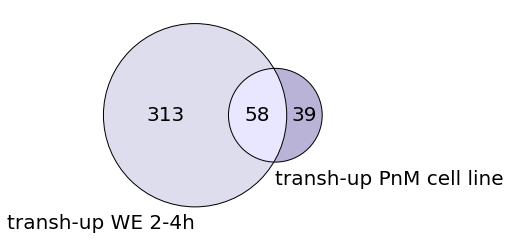

In [59]:
set1 = set(merged[merged["log2FoldChange_we"] > 0].index)
set2 = set(merged[merged["log2FoldChange_pnm"] > 0].index)

v = venn2([set1, set2], 
          set_labels = ("transh-up WE 2-4h", "transh-up PnM cell line"), 
          set_colors = ('#bcbddc', '#756bb1'),
          alpha = 0.5,
          subset_label_formatter=lambda x: f'{x:,}')
c = venn2_circles(subsets = [set1, set2], linestyle='solid', linewidth=1, color="black")

for text in v.set_labels:
    text.set_fontsize(20)

for text in v.subset_labels:
    text.set_fontsize(20)
    
plt.savefig(figures + "transh-up_venn.svg", bbox_inches='tight')

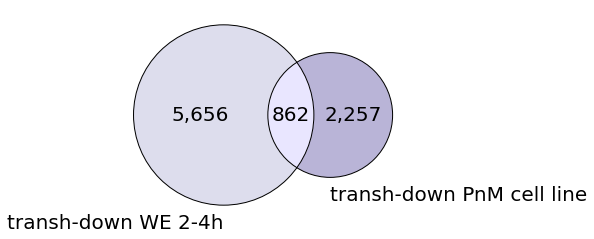

In [60]:
set1 = set(merged[merged["log2FoldChange_we"] < 0].index)
set2 = set(merged[merged["log2FoldChange_pnm"] < 0].index)

v = venn2([set1, set2], 
          set_labels = ("transh-down WE 2-4h", "transh-down PnM cell line"), 
          set_colors = ('#bcbddc', '#756bb1'),
          alpha = 0.5,
          subset_label_formatter=lambda x: f'{x:,}')
c = venn2_circles(subsets = [set1, set2], linestyle='solid', linewidth=1, color="black")

for text in v.set_labels:
    text.set_fontsize(20)

for text in v.subset_labels:
    text.set_fontsize(20)
    
plt.savefig(figures + "transh-down_venn.svg", bbox_inches='tight')

# Contacts clustering

In [61]:
def assign_bin_pair_type(l2fc):
    if l2fc > 0:
        return "transUP"
    else:
        return "transDOWN"

## Violin plots for global differences

WE
Calculate std
Save std to file
Violin plots
transUP_cish vs. transUP_transh: Custom statistical test, P_val:0.000e+00
transDOWN_cish vs. transDOWN_transh: Custom statistical test, P_val:4.017e-01
PnM
Calculate std
Save std to file
Violin plots
transUP_cish vs. transUP_transh: Custom statistical test, P_val:1.082e-110
transDOWN_cish vs. transDOWN_transh: Custom statistical test, P_val:0.000e+00


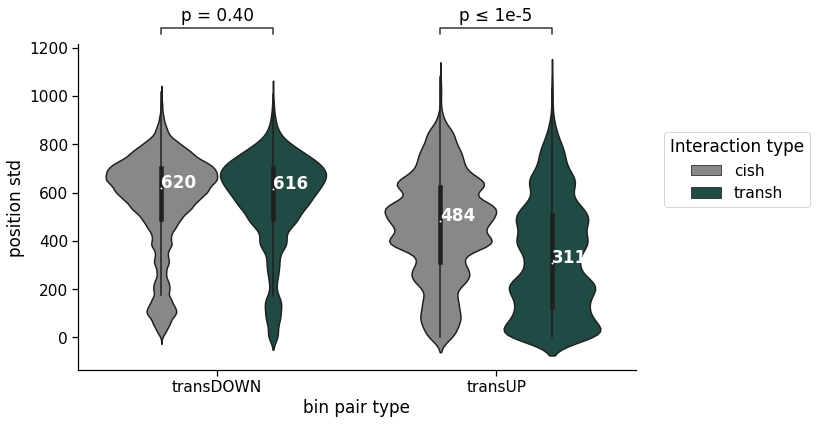

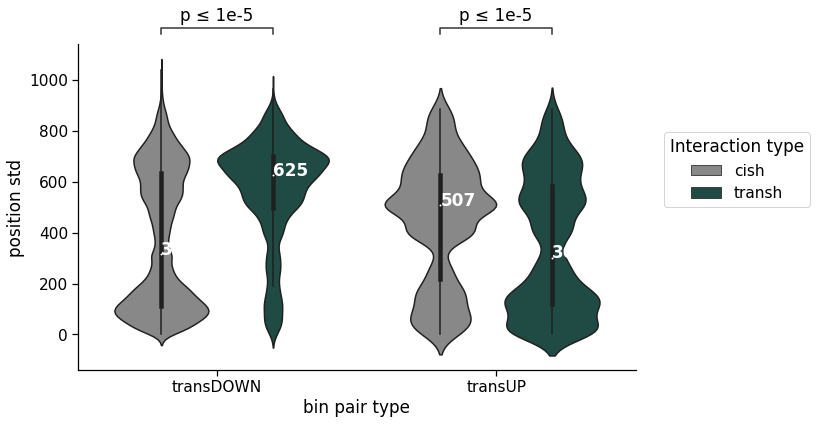

In [73]:
positions_std = {}
contacts_in_significant_bins = {}
for prefix in ["WE", "PnM"]:
    print(prefix)
    print("Calculate std")
    contacts_bins_std = pd.DataFrame()
    
    significant_pairs = significant_results[prefix]
    significant_pairs["bin_name1"] = "chr" + significant_pairs.index.str.split("_chr").str[1]
    significant_pairs["bin_name2"] = "chr" + significant_pairs.index.str.split("_chr").str[2]
    significant_pairs["bin pair type"] = significant_pairs.log2FoldChange.apply(assign_bin_pair_type)
    
    merged_replicates_diff_bins_significant = pd.merge(contacts[prefix], 
                                                       significant_pairs[["bin_name1", "bin_name2", "bin pair type"]].drop_duplicates(), 
                                                       on = ["bin_name1", "bin_name2"], how = "inner")
    
    contacts_in_significant_bins[prefix] = merged_replicates_diff_bins_significant
    
    for name, group in merged_replicates_diff_bins_significant.groupby(["bin_name1", "bin_name2"]):
        group["std1"] = np.std(group["pos1"].values)    
        group["std2"] = np.std(group["pos2"].values)
        group["num_contacts"] = len(group)
        contacts_bins_std = pd.concat([contacts_bins_std, group])
        
    print("Save std to file")
    contacts_bins_std.to_csv(tables + prefix + "_positions_std.csv", sep = "\t", index = False)
    positions_std[prefix] = contacts_bins_std
    
    contacts_bins_std_long = pd.melt(contacts_bins_std, id_vars = ["bin pair type", "transh", "num_contacts"], 
                                     value_vars = ["std1", "std2"], value_name = "position std")

    contacts_bins_std_long = contacts_bins_std_long.rename(columns = {"transh" : "contact type"})
    contacts_bins_std_long["contact type"] = contacts_bins_std_long["contact type"].apply(lambda x: {True: "transh", False: "cish"}[x])
    
    print("Violin plots")

    pairs = [(("transDOWN", "cish"), ("transDOWN", "transh")),
             (("transUP", "cish"), ("transUP", "transh"))]

    UP_transh = contacts_bins_std_long[(contacts_bins_std_long["bin pair type"]=="transUP") & (contacts_bins_std_long["contact type"]=="transh")]["position std"]
    DOWN_transh = contacts_bins_std_long[(contacts_bins_std_long["bin pair type"]=="transDOWN") & (contacts_bins_std_long["contact type"]=="transh")]["position std"]
    UP_cish = contacts_bins_std_long[(contacts_bins_std_long["bin pair type"]=="transUP") & (contacts_bins_std_long["contact type"]=="cish")]["position std"]
    DOWN_cish = contacts_bins_std_long[(contacts_bins_std_long["bin pair type"]=="transDOWN") & (contacts_bins_std_long["contact type"]=="cish")]["position std"]

    pvalues = [r[1] for r in [stats.mannwhitneyu(DOWN_cish, DOWN_transh), stats.mannwhitneyu(UP_cish, UP_transh)]]
    formatted_pvalues = ["padj.=%.2f" % p for p in pvalues]

    contact_type_palette ={"transh": "#185249", "cish": "#888888"}

    plot_params = {
        'data' : contacts_bins_std_long,
        'x' : "bin pair type",
        'y' :  "position std",
        'order' : ["transDOWN", "transUP"],
        'hue_order' : ["cish", "transh"],
        'palette' : contact_type_palette,
        'hue' : "contact type"
    }

    with sns.plotting_context('notebook', font_scale=1.4):
        fig, ax = plt.subplots(1, 1, figsize=(10,6))
        sns.violinplot(ax=ax, **plot_params)
        annotator = Annotator(ax, pairs, **plot_params)
        annotator.configure(text_format="simple", text_offset=3, loc='outside')
        annotator.set_pvalues(pvalues).annotate()

        medians = [DOWN_cish.median(), DOWN_transh.median(), UP_cish.median(), UP_transh.median()]
        locations = [-0.2, 0.2, 0.8, 1.2]

        for i, value in enumerate(medians):
            plt.text((locations[i]), (value), "%.0f" % value, color = "white", fontweight = "bold")

        ax.legend(title = "Interaction type", loc=(1.05, 0.5))
        sns.despine()
        plt.savefig(figures + "%s_positions_std_violins.svg" % prefix, bbox_inches='tight')

## Scatter plots for examples

In [68]:
contacts_in_significant_bins_WE = pd.read_csv(tables + "WE_positions_std.csv", sep = "\t")
contacts_in_significant_bins_WE["pos1 from bin start"] = contacts_in_significant_bins_WE["pos1"] - contacts_in_significant_bins_WE["bin_name1"].str.split(":").str[1].str.split("-").str[0].astype(int)
contacts_in_significant_bins_WE["pos2 from bin start"] = contacts_in_significant_bins_WE["pos2"] - contacts_in_significant_bins_WE["bin_name2"].str.split(":").str[1].str.split("-").str[0].astype(int)
transUP = contacts_in_significant_bins_WE[contacts_in_significant_bins_WE["bin pair type"] == "transUP"]
transDOWN = contacts_in_significant_bins_WE[contacts_in_significant_bins_WE["bin pair type"] == "transDOWN"]
transUP.head()

,chrom,pos1,strand1,h1,pos2,strand2,h2,transh,pos1-1,pos2-1,...,replicate,dist,bin_name1,bin_name2,bin pair type,std1,std2,num_contacts,pos1 from bin start,pos2 from bin start
7224,chr2L,10948048,-,DGRP-439,16264491,-,DGRP-439,False,10948047,16264490,...,Rep1,5316443,chr2L:10947500-10950000,chr2L:16262500-16265000,transUP,30.240157,27.088751,21,548,1991
7225,chr2L,10947977,DGRP-439,DGRP-439,16264402,DGRP-57,DGRP-57,True,10947976,16264401,...,Rep1,5316425,chr2L:10947500-10950000,chr2L:16262500-16265000,transUP,30.240157,27.088751,21,477,1902
7226,chr2L,10947977,DGRP-439,DGRP-439,16264403,DGRP-57,DGRP-57,True,10947976,16264402,...,Rep1,5316426,chr2L:10947500-10950000,chr2L:16262500-16265000,transUP,30.240157,27.088751,21,477,1903
7227,chr2L,10948048,-,DGRP-439,16264480,-,DGRP-439,False,10948047,16264479,...,Rep1,5316432,chr2L:10947500-10950000,chr2L:16262500-16265000,transUP,30.240157,27.088751,21,548,1980
7228,chr2L,10947977,DGRP-439,DGRP-439,16264402,DGRP-57,DGRP-57,True,10947976,16264401,...,Rep1,5316425,chr2L:10947500-10950000,chr2L:16262500-16265000,transUP,30.240157,27.088751,21,477,1902


In [69]:
def format_coordinates(coordinates):
    chrom = coordinates.split(":")[0]
    start = int(coordinates.split(":")[1].split("-")[0])
    end = int(coordinates.split("-")[1])
    with_thousand_sep = chrom + ":" + f'{start:,}' + "-" + f'{end:,}'
    return with_thousand_sep

In [70]:
def plot_scatter(name, group, type_prefix, counter):
    group_melted = group.melt(value_vars = ["pos1 from bin start", "pos2 from bin start"], id_vars = "transh",
                            value_name = "position in bin", var_name = "bin")
    group_melted["bin"] = group_melted.bin.apply(lambda x: {"pos1 from bin start" : name[0], "pos2 from bin start" : name[1]}[x])
    group_melted["bin"] = group_melted.bin.apply(format_coordinates)
    group_melted["transh"] = group_melted.transh.apply(lambda x: {True: "transh", False: "cish"}[x])
    contact_type_palette ={"transh": "#185249", "cish": "#888888"}

    g = (sns.catplot(data = group_melted.sort_values(by = "transh"), x = "position in bin", y = "transh", hue = "transh",
                    palette = contact_type_palette, orient="h", jitter=True, alpha = 0.7, legend=False,
                    hue_order = ["cish", "transh"], col="bin", kind = "strip", height = 2, aspect = 4)
        .set(xlim=(0,2500), yticks=[], ylabel=None)
        .add_legend(bbox_to_anchor=(0.9, 1), loc='upper left', borderaxespad=0, title="Contact type"))

    
    sns.despine(left=True)            
    plt.subplots_adjust(wspace = 0.2)
    
    for bin_name, bin_data in group_melted.groupby(["bin"]):
        print(bin_name)
        bin_trans = bin_data[bin_data["transh"] == "transh"]["position in bin"]
        bin_cish = bin_data[bin_data["transh"] == "cish"]["position in bin"]
        #print(stats.mannwhitneyu(bin_trans, bin_cish)) 

    plt.savefig(figures + "{}_scatter{}.svg".format(type_prefix, counter), bbox_inches='tight')

chr2L:14,880,000-14,882,500
chr2L:14,882,500-14,885,000
chr2R:10,417,500-10,420,000
chr2R:10,425,000-10,427,500
chr3R:31,995,000-31,997,500
chr3R:31,997,500-32,000,000
chr2L:10,000,000-10,002,500
chr2L:10,002,500-10,005,000
chr2R:10,140,000-10,142,500
chr2R:10,142,500-10,145,000
chr2R:10,175,000-10,177,500
chr2R:10,185,000-10,187,500


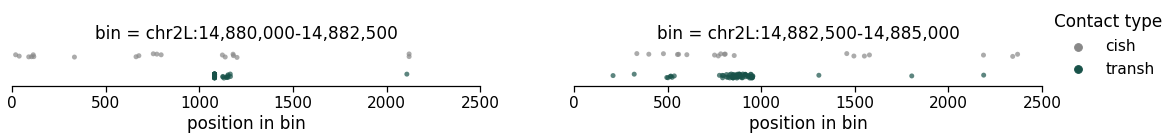

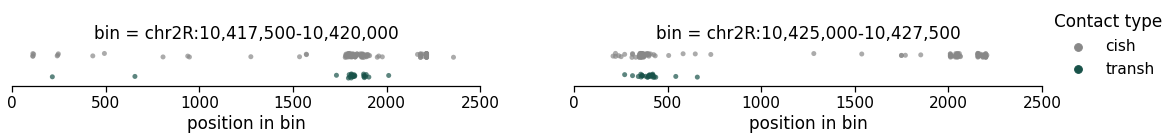

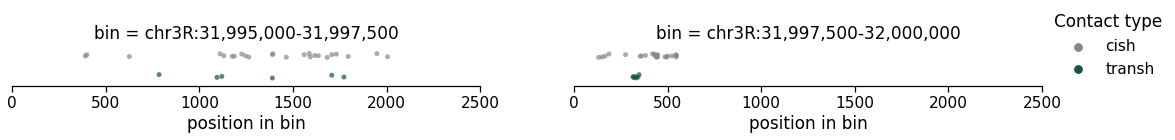

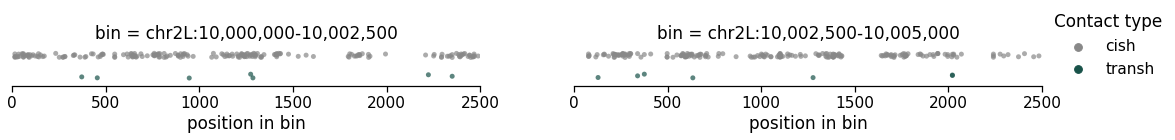

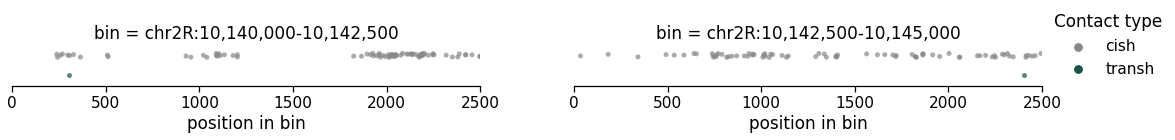

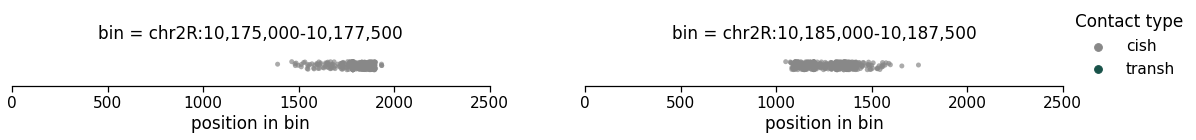

In [71]:
with sns.plotting_context('notebook', font_scale=1.4):
    for type_prefix, dataset in [("transUP", transUP), ("transDOWN", transDOWN)]:
        counter = 1
        for name, group in dataset.groupby(["bin_name1","bin_name2"]):
            if type_prefix == "transUP":    
                #first - example selected for poster, second and third - heph gene
                if "14880000" in name[0] or ("3R" in name[0] and int(name[0].split('-')[1]) == 31997500) or ("2R" in name[0] and int(name[1].split('-')[1]) == 10427500):    
                    plot_scatter(name, group, type_prefix, counter)
                    counter += 1
            else:
                #example selected for poster
                if "10000000-" in name[0] or ("2R" in name[0] and int(name[0].split('-')[1]) == 10142500) or ("2R" in name[0] and int(name[0].split('-')[1]) == 10177500):
                    plot_scatter(name, group, type_prefix, counter)
                    counter += 1

**** transUP *****
chr2R:10,417,500-10,420,000
chr2R:10,422,500-10,425,000
chr2R:10,417,500-10,420,000
chr2R:10,425,000-10,427,500
chr2R:10,422,500-10,425,000
chr2R:10,427,500-10,430,000
chr2R:12,507,500-12,510,000
chr2R:12,510,000-12,512,500
chr2R:1,282,500-1,285,000
chr2R:4,165,000-4,167,500
chr2R:13,072,500-13,075,000
chr2R:13,110,000-13,112,500
chr2R:14,320,000-14,322,500
chr2R:14,337,500-14,340,000
chr2R:15,372,500-15,375,000
chr2R:15,375,000-15,377,500
chr2R:16,070,000-16,072,500
chr2R:16,075,000-16,077,500
**** transDOWN *****
chr2R:10,140,000-10,142,500
chr2R:10,142,500-10,145,000
chr2R:10,142,500-10,145,000
chr2R:10,145,000-10,147,500
chr2R:10,175,000-10,177,500
chr2R:10,185,000-10,187,500
chr2R:10,252,500-10,255,000
chr2R:10,257,500-10,260,000
chr2R:10,260,000-10,262,500
chr2R:10,262,500-10,265,000
chr2R:10,262,500-10,265,000
chr2R:10,270,000-10,272,500
chr2R:10,317,500-10,320,000
chr2R:10,320,000-10,322,500
chr2R:10,320,000-10,322,500
chr2R:10,322,500-10,325,000
chr2R:10,432

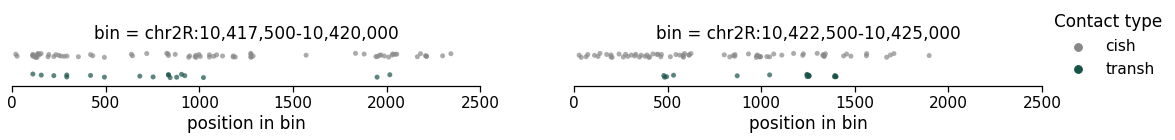

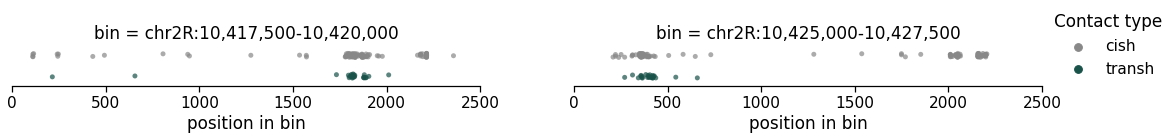

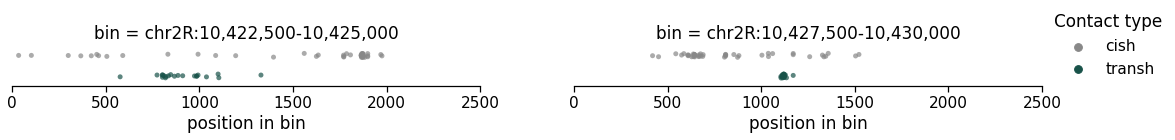

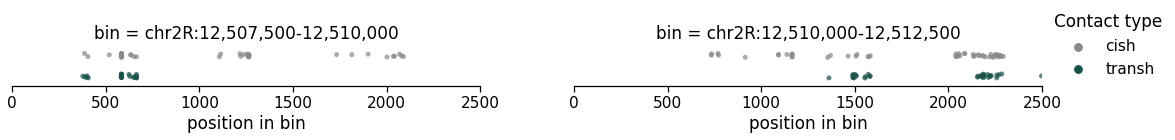

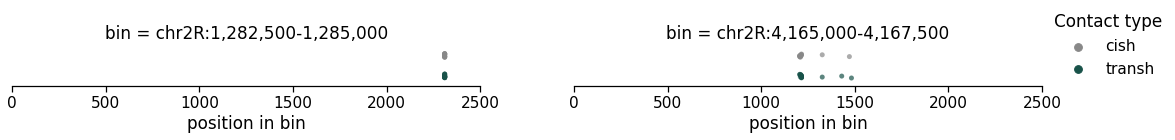

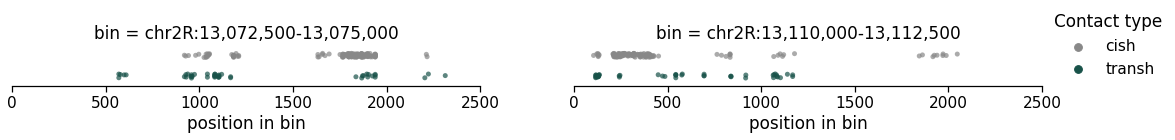

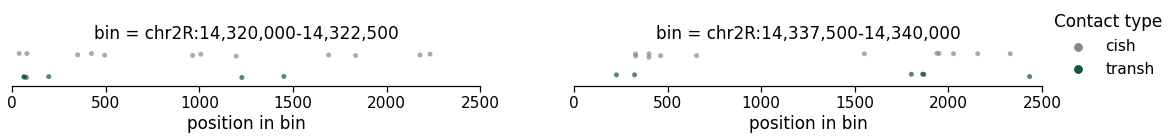

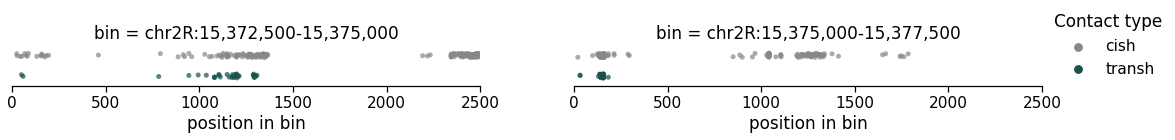

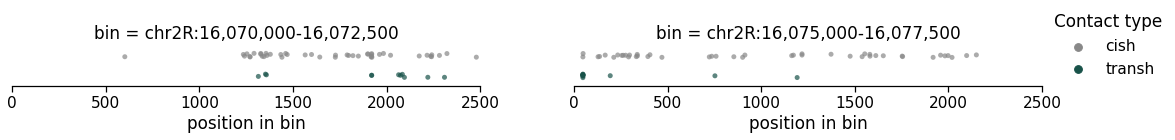

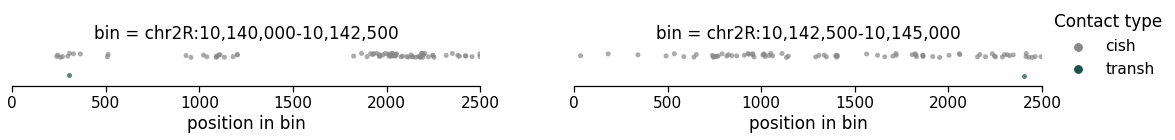

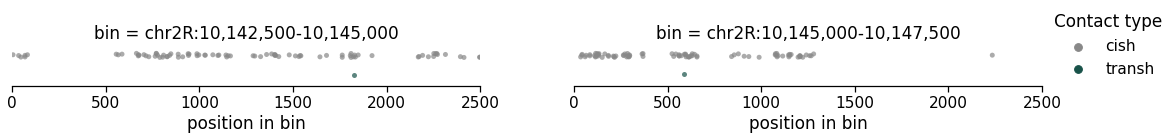

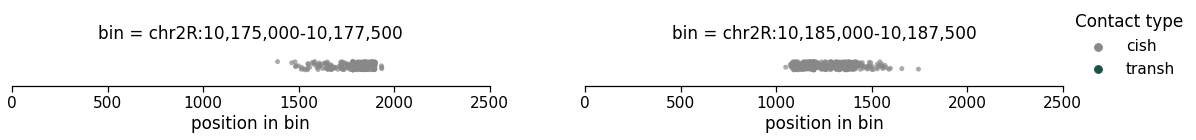

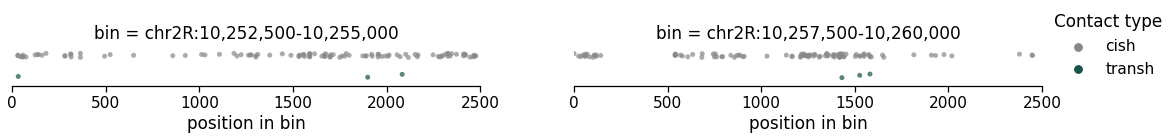

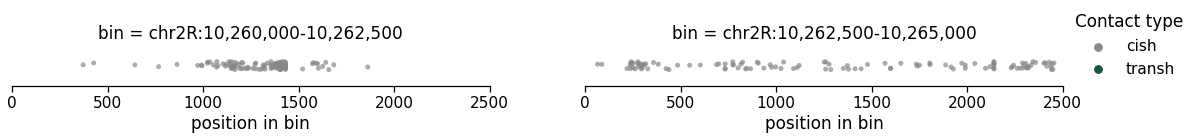

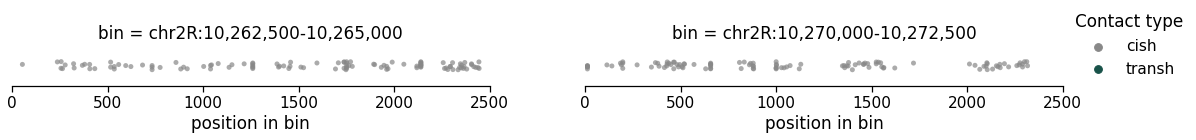

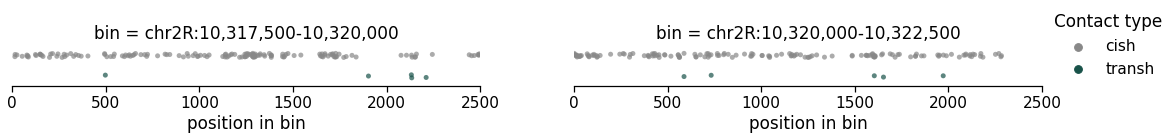

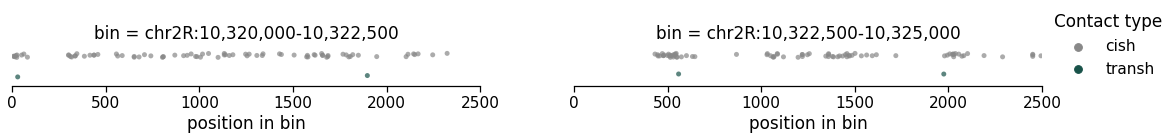

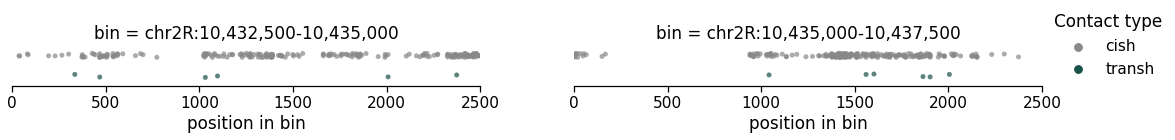

In [72]:
with sns.plotting_context('notebook', font_scale=1.4):
    for type_prefix, dataset in [("transUP", transUP), ("transDOWN", transDOWN)]:
        print("****", type_prefix, "*****")
        counter = 1
        for name, group in dataset.groupby(["bin_name1","bin_name2"]):
            if type_prefix == "transUP":
                if counter < 10:
                    if "2R" in name[0]:
                        #first - example selected for poster, second and third - heph gene
                        #if "14880000" in name[0] or ("3R" in name[0] and int(name[0].split('-')[1]) > 31844038 and int(name[1].split('-')[1]) < 32025378):    
                        plot_scatter(name, group, type_prefix, counter)
                        counter += 1
            else:
                if counter < 10:
                    if "2R" in name[0]:
                        #example selected for poster
                        #if "10000000-" in name[0] or "10025000-" in name[0]:
                        plot_scatter(name, group, type_prefix, counter)
                        counter += 1